In [81]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (25, 5)
import seaborn as sns

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import logResults


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
EXPERIMENT_NAME = 'Experiment_template'

## Set configuration

In [86]:
#Use default cfg, alternatively overwrite values
cfg = defaultCfg

#Set model specific config
cfg.enc_hidden_dim = [cfg.obs_dim, cfg.factor_dim]
cfg.dec_hidden_dim = [cfg.factor_dim, cfg.obs_dim]
cfg.enc_activation = nn.Tanh
cfg.dec_activation = nn.Tanh
cfg.enc_last_layer_linear = False
cfg.dec_last_layer_linear = False

#set experiment specifig training params
cfg.lr = 0.0005
cfg.max_iter = 50

cfg.use_default_data = False

## Obtain Data
Obtain the simulated $y$ and $f$

In [87]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim, 50, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False, use_xavier=False)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

Obtained stable system after 153 iterations.


ValueError: mean and cov must have same length

In [69]:
#torch.save(dec, '../DGP/saved/dec_2.pt')
#np.save(arr=y, file='../DGP/saved/y_2.npy')
#np.save(arr=f, file='../DGP/saved/f_2.npy')

## Estimate autoencoder model

In [70]:
dec = Decoder(hidden_dim=cfg.dec_hidden_dim, activation=cfg.dec_activation, lastLayerLinear=cfg.dec_last_layer_linear)
enc = Encoder(hidden_dim=cfg.enc_hidden_dim, activation=cfg.enc_activation, lastLayerLinear=cfg.enc_last_layer_linear)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
metrics = [CCACorr(f_train=f_train, f_val=f_val)]

train_hist = trainMCMC(X_train=y_train, X_val = y_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter = cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")


/Users/julianvanmeggelen/Documents/Studie/2022:23/Thesis/Simulation/../BasicAutoEncoder/model.py:54: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


Number of trainable paramaters 1105
torch.Size([4096, 100]) torch.Size([512, 100])
1 1.1304386407136917407136917
2 0.15191638097167015097167015
3 0.12093465495854616495854616
4 0.08987546619027853619027853
5 0.06523659918457279918457275
6 0.048914036247879276247879274
7 0.037839765194803476194803476
8 0.030352278845384717845384717
9 0.025104260770604014770604014
10 0.02154525322839617728396177
11 0.01952237309888005398880053
12 0.01666644634678966346789652
13 0.01282012253068387530683875
14 0.00988234335090965350909653
15 0.007180160901043564010435645
16 0.00573217083001509330015093
17 0.004828590201213956012139566
18 0.004400366044137627441376275
19 0.004204627417493612174936124
20 0.004030964511912316119123166
21 0.003921126830391586303915867
22 0.003842962236376479363764793
23 0.003735460806638002466380024
24 0.003683251998154446581544465
25 0.003623731288826093888260937
26 0.003564850892871618328716183
27 0.003510385926347226263472267
28 0.003484103159280494592804944
29 0.003426008

In [71]:
logResults(train_hist, mod, cfg, EXPERIMENT_NAME)

./Results/2/1_Experiment_template_05092023_22:06:07


### Train & val loss

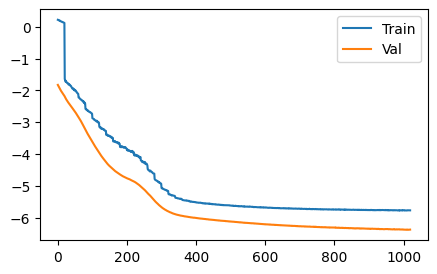

In [72]:
plot_train_hist(train_hist, log=True)

### Convergence of mu of epsilon

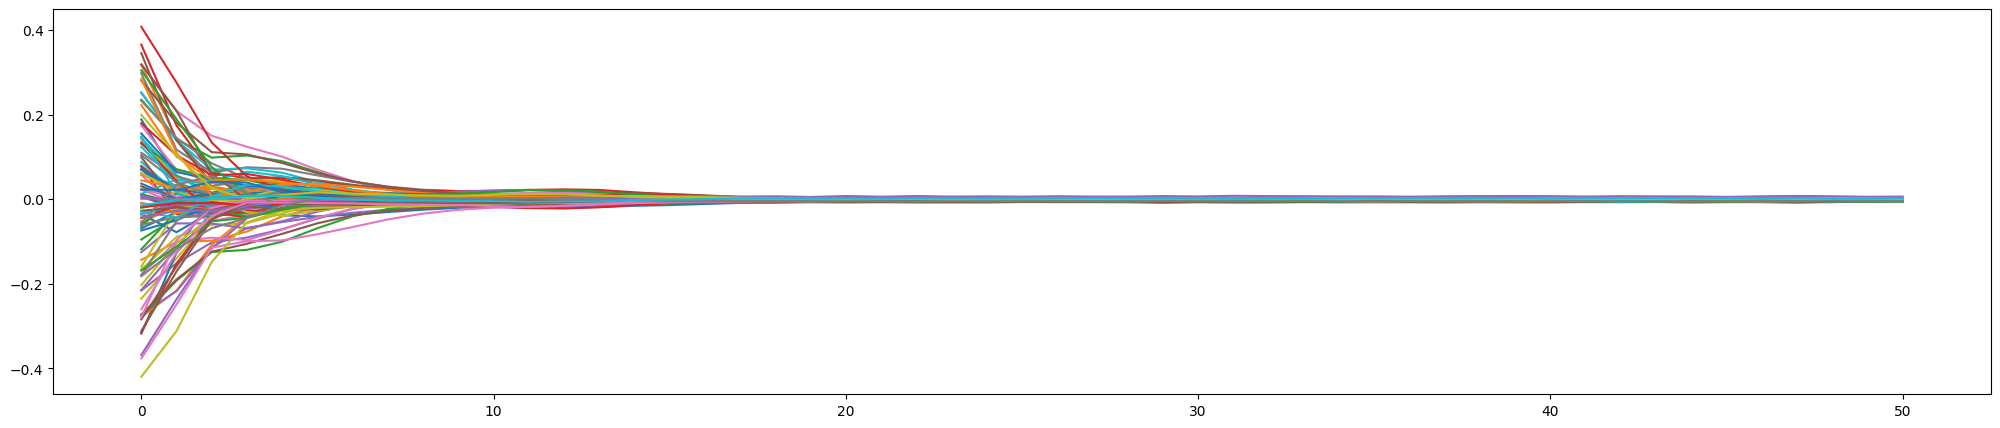

In [73]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

### Reconstruction of y

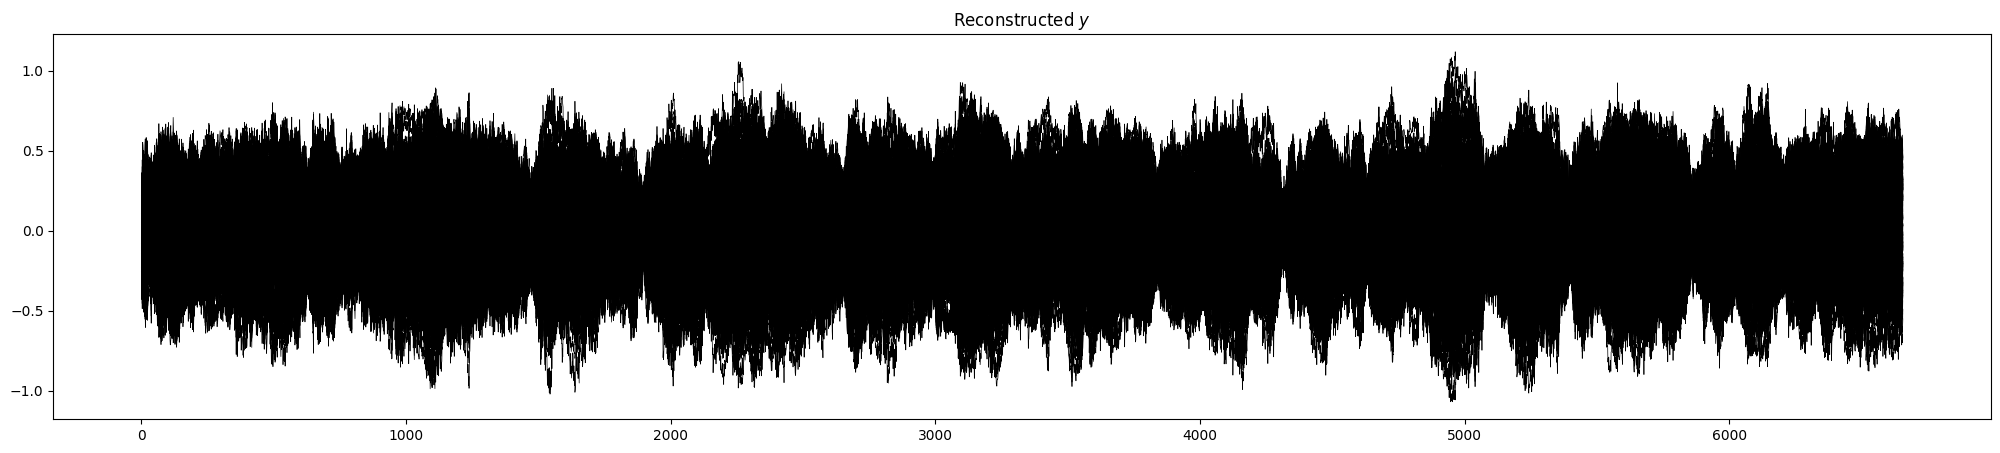

In [74]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


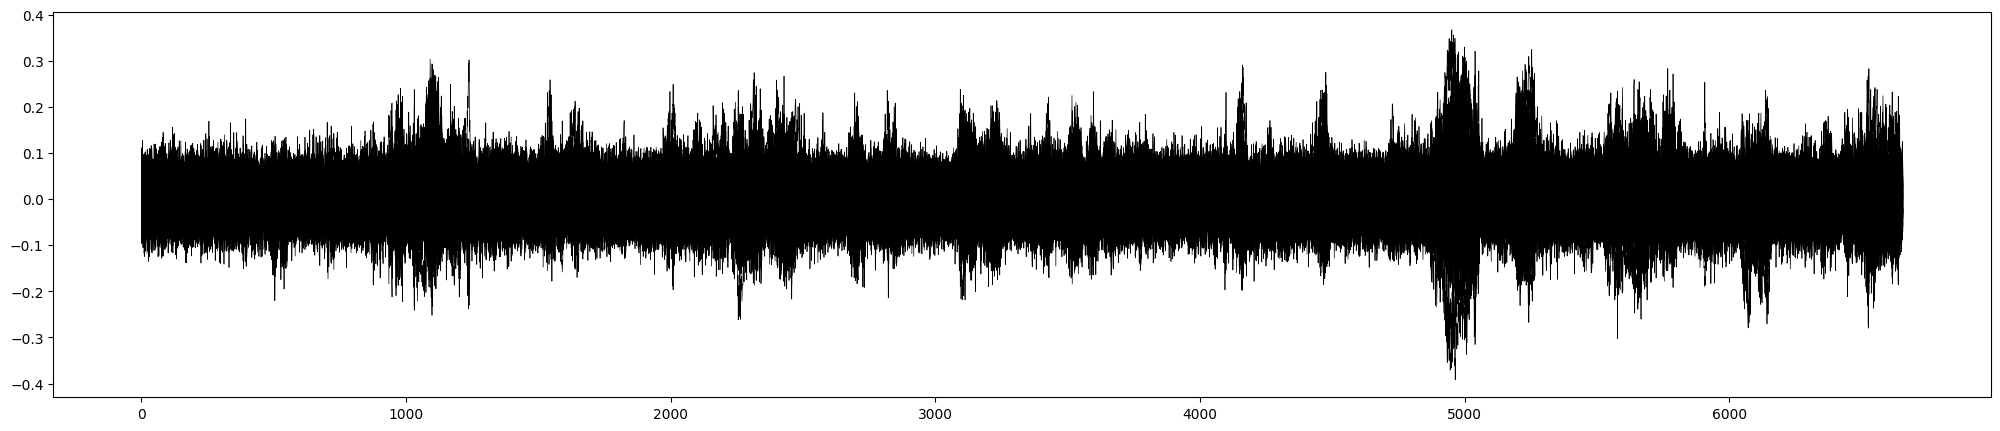

In [75]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

### Factor estimation

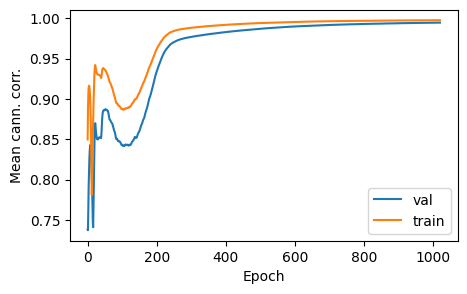

In [80]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['val_CCA_mean_corr'], label='val')
plt.plot(train_hist['train_CCA_mean_corr'], label='train')

plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')
plt.legend()

In [77]:
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

cc on train data: 0.9976563642810469
cc on test data: 0.9953631322923948
cc on train data:  0.9976562226486951
cc on test data:  0.9953629264379167


/Users/julianvanmeggelen/Library/Python/3.9/lib/python/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


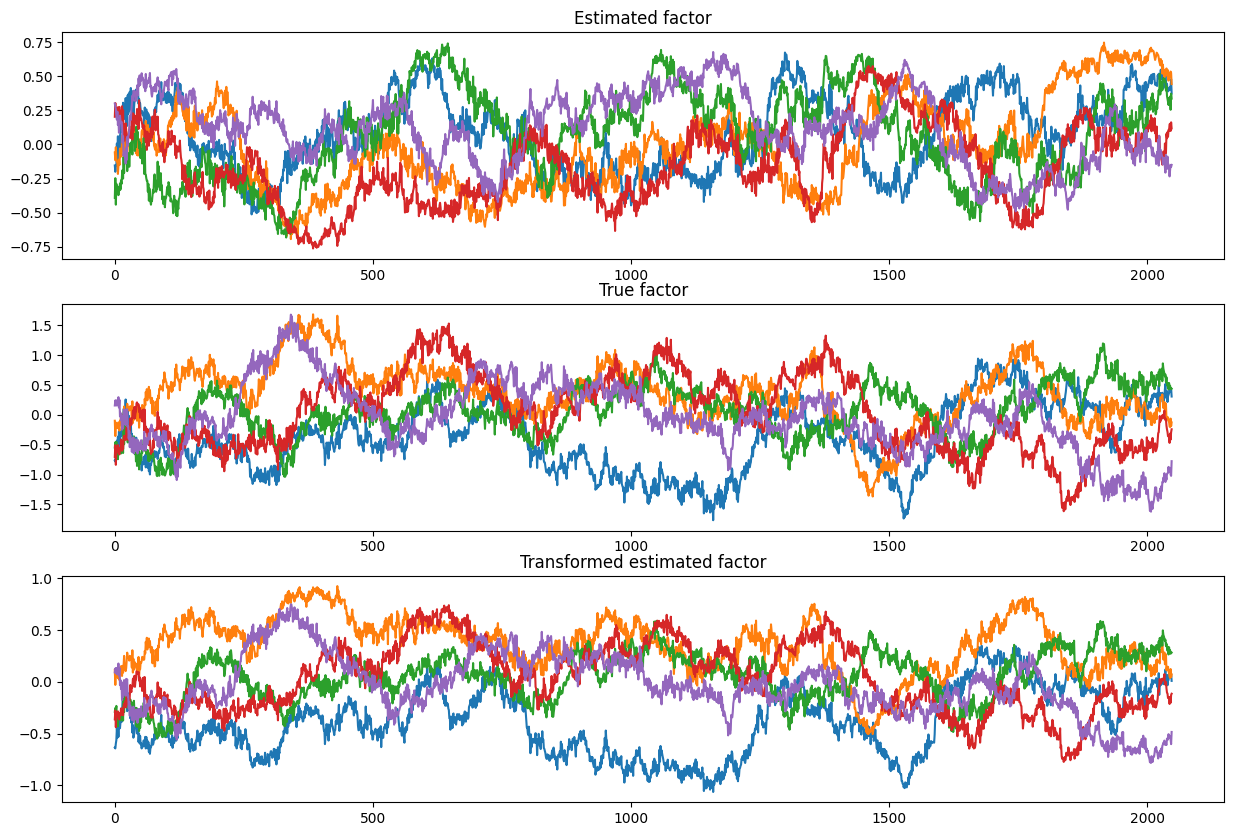

In [78]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

### Forecast

1-step ahead  FMSE on the test set: 0.004881475120782852


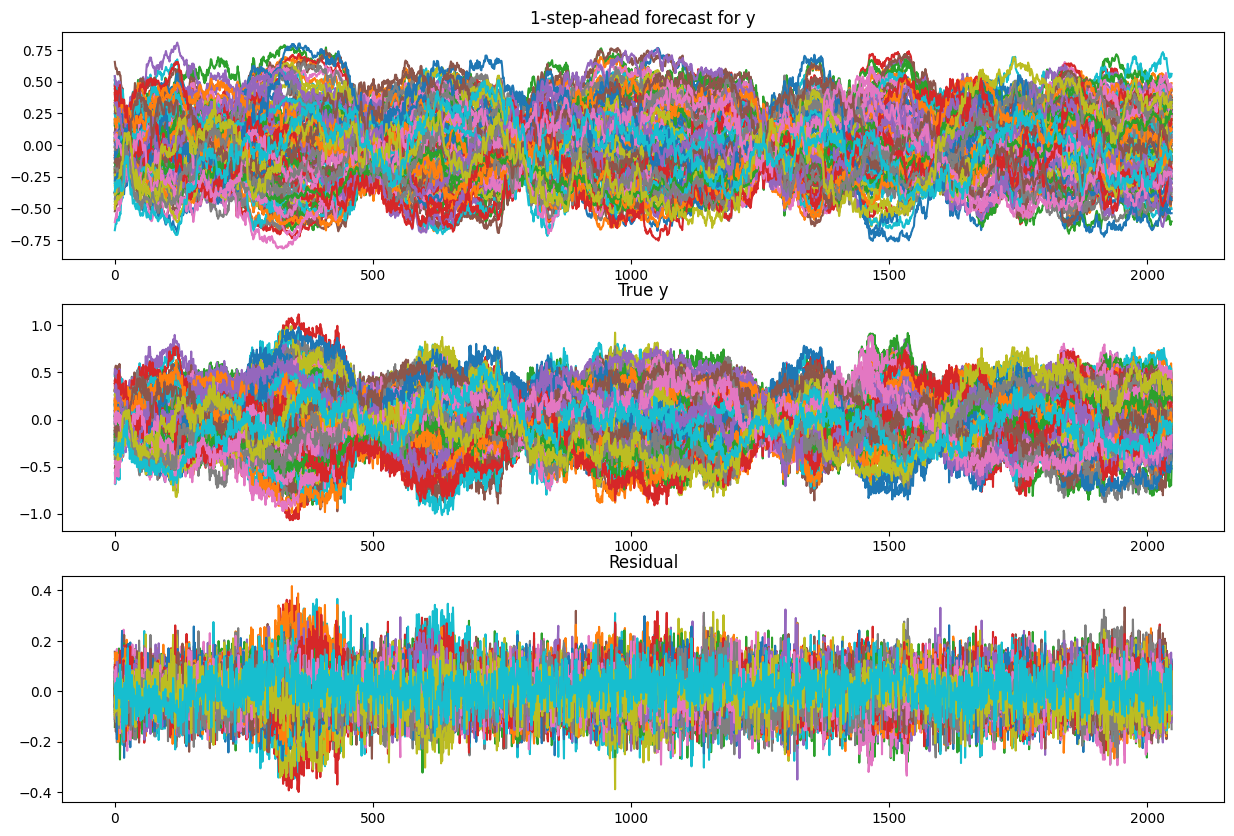

In [79]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[-cfg.T_test:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")